<h3>Logistic Regression</h3>
<h4>Packages Used</h4>
<ul>
    <li>numpy</li>
    <li>matplotlib</li>
    <li>scipy</li>
</ul>
<h3>Import necessary packages</h3>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]

<h3>ReadData(data,separator): Helper function to read data</h3>
<h4> Assumes data is of the form X[0], X[1], ..., X[n], Y</h4>
<h5>Where X[i] is a feature and Y is the label</h5> 

In [3]:
def ReadData(data,separator):
    
    XY =  np.genfromtxt(data, delimiter=separator)
    m=XY.shape[0]
    Y=XY[:,-1].reshape(m,1)
    X=XY[:,0:-1]
    return X,Y,m

<h3>Normalize(data): Helper function to Normalize data</h3>

In [4]:
def Normalize(data):
    
    Mu = np.mean(X, axis=0)
    Sigma = np.std(X, axis=0)
    data = ((data-Mu)/Sigma)
    return data, Mu, Sigma

In [5]:
def mapFeature(X1, X2):
# MAPFEATURE Feature mapping function to polynomial features
#
#   MAPFEATURE(X1, X2) maps the two input features
#   to quadratic features used in the regularization exercise.
#
#   Returns a new feature array with more features, comprising of 
#   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
#   for a total of 1 + 2 + ... + (degree+1) = ((degree+1) * (degree+2)) / 2 columns
#
#   Inputs X1, X2 must be the same size

    degree = 6
    out = np.matrix(np.ones(X1.shape[0])).T
    for i in range(1,degree+1):
        for j in range(i+1):
            out = np.c_[out,np.multiply(np.power(X1,i-j),np.power(X2,j))]
    return out

<h3>GradientDescent(theta, X, Y, m, lambd): Function to calculate the Gradient</h3>

In [6]:
def GradientDescent(theta,*args):
    X,Y,m,lambd = args[0],args[1],args[2],args[3]
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    grad = np.ones((theta.shape[0],1))
    H = Sigmoid(np.dot(X, theta))
    diff = H - Y
    grad = (np.dot(X.T,diff) / m) + (theta * (lambd/m))
    grad[0,0] = grad[0,0] - (theta[0,0] * (lambd/m))
    grad = np.squeeze(np.array(grad))
    return grad

<h3>GradientDescentCheck(theta, X, Y, m, lambd): Function to cheeck the Gradient</h3>

In [7]:
def GradientDescentCheck(theta,*args):
    X,Y,m,lambd = args[0],args[1],args[2],args[3]
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    epislon = 0.0001
    numgrad = np.zeros((theta.shape[0],1)) 
    for i in range(numgrad.shape[0]):
        newtheta = theta
        newtheta[i,0] = newtheta[i,0] + epislon
        loss1,_ = CostCalc(newtheta,X,Y,m,lambd)
        newtheta[i,0] = newtheta[i,0] -  (2 * epislon)
        loss2,_ = CostCalc(newtheta,X,Y,m,lambd)
        numgrad[i,0] = (loss1 - loss2) / (2 * epislon)
    return np.squeeze(np.array(numgrad))

<h3>CostCalc(X,theta,bias,Y,costweight): Function to calculate Cost, Gradient</h3>

In [8]:
def CostCalc(theta,*args):
    X,Y,m,lambd = args[0],args[1],args[2],args[3]
    #Reshape theta as op.minimize gives different type of numpy data structure
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    
    H = Sigmoid(np.dot(X,theta))
    diff = H - Y
    grad = (np.dot(X.T,diff) / m) + (theta * (lambd/m))
    grad[0,0] = grad[0,0] - (theta[0,0] * (lambd/m))
    J = (-(np.dot(Y.T,np.log(H)) + np.dot((1-Y).T,np.log(1-H)))/m) + ((lambd/(2*m)) * np.sum(np.square(theta)))
    J[0,0] = J[0,0] - ((lambd/(2*m)) * np.square(theta[0,0]))
    grad = np.squeeze(np.array(grad))
    J = np.squeeze(np.array(J))
    return J,grad

<h3>PlotData(theta,X,Y,mapFeatures,fignumber=1,res = 200): Helper function to Plot data, contour plot</h3>

In [9]:
def PlotData(theta,X,Y,mapFeatures,fignumber=1,res = 200):

    plt.style.use('ggplot')
    plt.figure(fignumber)
    plt.subplot(111)
    X1 = np.array([[X[i,0],X[i,1]] for i in range(len(X)) if Y[i,0] == 1])
    X0 = np.array([[X[i,0],X[i,1]] for i in range(len(X)) if Y[i,0] == 0])
    plt.plot(X0[:,0],X0[:,1],'ro',label='class 0')
    plt.plot(X1[:,0],X1[:,1],'bo',label='class 1')
    plt.ylabel('Feature 2')
    plt.xlabel('Feature 1')
    plt.legend(bbox_to_anchor=(0.80, 1.15), loc=2,mode="expand", borderaxespad=0.)
    ContourPlot(theta, X,mapFeatures,res)
    return

In [10]:
def ContourPlot(theta, X, mapFeatures, res = 100):
## res is the resolution of the x,y plane that is used to plot the contour data
## higher res gives smother contour at the cost of computation time
    Y = np.linspace(min(X[:,1]), max(X[:,1]), res)
    X = np.linspace(min(X[:,0]), max(X[:,0]), res)
    Z = ContourPlotCalc(theta, X, Y, mapFeatures)
    X , Y = np.meshgrid(X, Y)
    CS = plt.contour(X, Y, Z,colors='k', alpha=.5)
    CS1 = plt.contourf(X, Y, Z,cmap='RdBu', alpha=.5)
    
    return

################################################################################
################################################################################    

def ContourPlotCalc(theta, X, Y, mapFeatures):
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    X1 = np.array([ (x,y) for x in X for y in Y])
    if mapFeatures :
        X1 = mapFeature(X1[:,0], X1[:,1])
    Z = np.dot(X1,theta)
    Z = np.where(Z >= 0, 1, 0)
    Z = Z.reshape(len(X),len(Y))
    return Z

In [11]:
def Sigmoid(Z):
    Z = 1/(1 + np.exp(-Z))
    return Z

In [12]:
def Predict(theta, X):
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    P = np.dot(X,theta)
    P = np.where(P >= 0, 1, 0)
    return P

<h2>Main Code below</h2>

Checking Gradient descent

grad[0] = 0.3460450736792453,numgrad[0] = 0.34604507335833645
grad[1] = 0.08508073284023367,numgrad[1] = 0.08508265936013615
grad[2] = 0.1185245691713191,numgrad[2] = 0.11852633558406822
grad[3] = 0.1505915957843716,numgrad[3] = 0.15058995800565356
grad[4] = 0.015914488662613836,numgrad[4] = 0.015915663333920804

Relative difference should be very small and it is 4.0781980446365794e-06

Accuracy = 83.05084745762713 %
cost = 0.5290027422869218


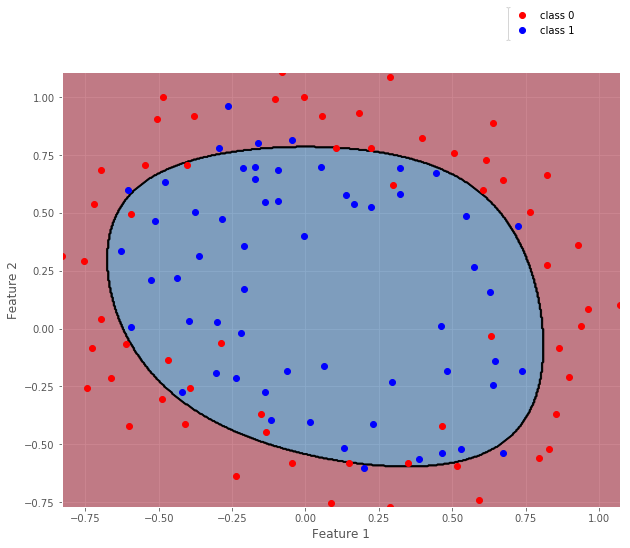

In [13]:
X,Y,m = ReadData('LogRegDS2.txt',',')
original_X = X
mapFeatures = True
X0 = np.array(X[:,0]).reshape(m,1)
X1 = np.array(X[:,1]).reshape(m,1)
X,Mu,Sigma = Normalize(X)
Norm_X = X
X = mapFeature(X0,X1)
theta = np.ones((X.shape[1],1))
lambd = 1
J,grad = CostCalc(theta,X,Y,m,lambd)
numgrad = GradientDescentCheck(theta,X,Y,m,lambd)
print('Checking Gradient descent\n')
for j in range(5):
    print(f'grad[{j}] = {grad[j]},numgrad[{j}] = {numgrad[j]}')
numgrad = np.array(numgrad)
grad = np.array(grad)
Relative_difference = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
print(f'\nRelative difference should be very small and it is {Relative_difference}\n')
initial_theta = np.squeeze(theta) * 0
Result = op.minimize(fun = CostCalc, x0 = initial_theta, args = (X,Y,m,lambd), method = 'BFGS', jac = True)
cost = Result.fun
trained_theta = Result.x
trained_theta = trained_theta.reshape(trained_theta.shape[0],1)
#print(cost,trained_theta)
P = Predict(trained_theta, X)
error = (1/m) * sum(np.abs(P-Y)) * 100
Accuracy = 100 - error[0]
print(f'Accuracy = {Accuracy} %\ncost = {cost}')
i = 1
res = 500
PlotData(trained_theta, original_X,Y,mapFeatures,i,res)
plt.show()